In [1]:
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pyarrow.parquet as pq

import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, GRU
from keras.models import load_model

plt.rcParams['axes.grid'] = True

In [2]:
root_dir = 'C:/Users/delst/OneDrive/Desktop/Code/Workspace/Crypto_V2'
sys.path.append(root_dir)

from A_Main.Configurations.setup_env import setup_environment
config = setup_environment(root_dir)

---

In [3]:
cryptos = ['BTC']
files = os.path.join(config.sdo_parq, 'BTCUSDT_raw.parquet')
df = pq.read_table(files).to_pandas()
df.drop(columns=['SYMBOL'], inplace=True)

In [4]:
df.head()

,OPEN,HIGH,LOW,CLOSE,VOLUME,QUOTE_ASSET_VOLUME,NUMBER_OF_TRADES,TAKER_BUY_BASE_ASSET_VOLUME,TAKER_BUY_QUOTE_ASSET_VOLUME,TARGET
OPEN_TIME,,,,,,,,,,
2017-09-16 10:00:00,3753.29,3753.29,3470.66,3480.00,175.251826,627740.727773,778,58.976979,209869.879391,0.393885
2017-09-16 11:00:00,3490.00,3678.22,3490.00,3630.06,113.728279,409919.978386,475,68.053148,246000.247708,0.390215
2017-09-16 12:00:00,3630.06,3667.99,3565.47,3630.00,51.172541,185265.726418,347,23.788116,86067.342374,0.360434
2017-09-16 13:00:00,3610.00,3729.99,3531.01,3674.98,60.480745,219448.905188,413,36.841835,134235.540313,0.398650
2017-09-16 14:00:00,3674.98,3800.00,3630.00,3630.00,58.984953,218953.333668,664,14.245711,53040.500428,0.451718


In [5]:
df, df_test = train_test_split(df, test_size=0.2, shuffle=False)

In [6]:
feature_cols_for_eng = ['OPEN','HIGH','LOW','CLOSE','VOLUME']
ror_col = 'CLOSE'

In [7]:
# Define the proportion for the split
test_proportion = 0.2
split_index = int(df.shape[0] * (1-test_proportion))

# Create training and testing dataframes
train_df = df[:split_index]
test_df = df[split_index:]

# Fit the scaler to the training data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_df[['CLOSE']].values)

# Scale the training and testing data
train_features = scaler.transform(train_df[['CLOSE']].values)
test_features = scaler.transform(test_df[['CLOSE']].values)

# Prepare the inputs for LSTM
def prepare_data(scaled_features, n_past):
    X, y = [], []
        
    for i in range(n_past, len(scaled_features)):
        X.append(scaled_features[i - n_past:i, 0])
        y.append(scaled_features[i, 0])

    return np.array(X), np.array(y)

n_future = 48  # N steps in future to predict
n_past = 48  # N past steps used to predict future

# Prepare training data
X_train, y_train = prepare_data(train_features, n_past)

# Prepare testing data
X_test, y_test = prepare_data(test_features, n_past)

In [8]:
# Load the model
model = load_model(os.path.join(config.model_dir, 'LSTM_BTC_20230807_accuracy0.95.h5'))

---

In [9]:
y_pred = model.predict(X_test)

237/237 [==============================] - 12s 43ms/step


In [10]:
# Unscale the predicted values
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

R2: 0.8937220618316074
RMSE: 3114.2504429393634
MAPE: 4.91997279548819
Accuracy: 95.08002720451181


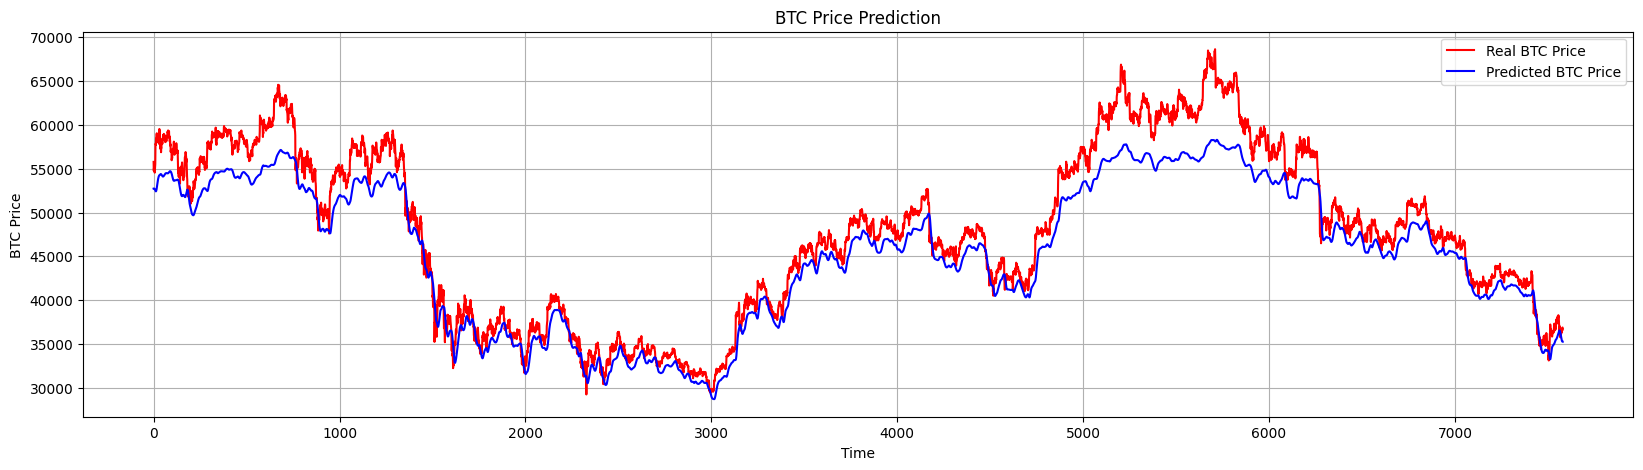

In [11]:
print('R2:', r2_score(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('MAPE:', np.mean(np.abs((y_test - y_pred) / y_test)) * 100) 
print('Accuracy:', 100 - np.mean(np.abs((y_test - y_pred) / y_test)) * 100)

plt.figure(figsize=(20, 5))
plt.plot(y_test, color='red', label='Real BTC Price')
plt.plot(y_pred, color='blue', label='Predicted BTC Price')
plt.title('BTC Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price')

plt.legend()
plt.show()

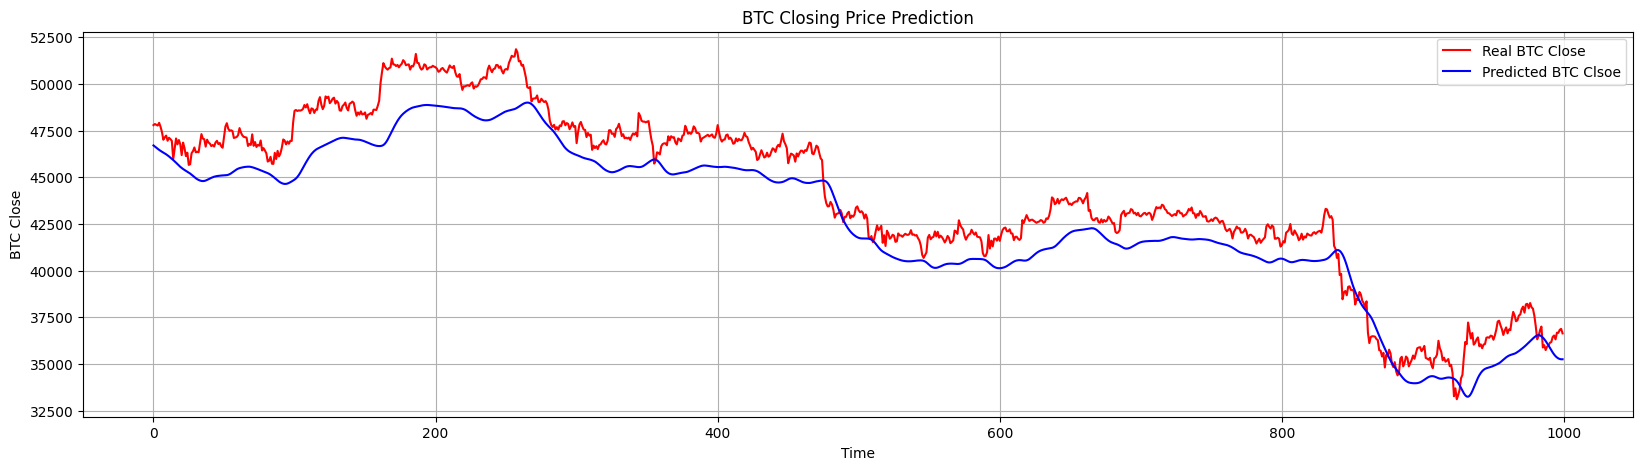

In [12]:
plt.figure(figsize=(20, 5))
plt.plot(y_test[-1000:], color='red', label='Real BTC Close')
plt.plot(y_pred[-1000:], color='blue', label='Predicted BTC Clsoe')
plt.title('BTC Closing Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Close')

plt.legend()
plt.show()

---